In [20]:
import re
import numpy as np
import xarray as xr
from datetime import datetime

# -------------------- helpers --------------------

def _next_nonempty(lines, j):
    n = len(lines)
    while j < n and not lines[j].strip():
        j += 1
    return j

def _read_block_floats(lines, j, nvals):
    """Read floats across as many lines as needed until nvals are collected."""
    vals = []
    n = len(lines)
    k = j
    while len(vals) < nvals and k < n:
        ln = lines[k].strip()
        if ln:
            vals.extend([float(t) for t in ln.split()])
        k += 1
    if len(vals) < nvals:
        raise ValueError("Unexpected EOF while reading numeric block.")
    return np.array(vals[:nvals], float), k

def _time_line_to_npdt(ln: str):
    """
    Parse lines like:
        20240925.000000                         date and time
    Returns np.datetime64 or None if not a time line.
    """
    if "date and time" not in ln.lower():
        return None
    tok = ln.split()[0]
    if "." not in tok:
        return None
    ymd, hms = tok.split(".")
    if len(hms) == 4:   # allow YYYYMMDD.HHMM
        hms += "00"
    dt = datetime.strptime(ymd + hms, "%Y%m%d%H%M%S")
    return np.datetime64(dt)

# -------------------- main parser --------------------

def read_swan_spec(path):
    """
    Read a SWAN ASCII .spec file (variant with single QUANT header, then repeated
    'date and time' blocks with optional FACTOR and NF×ND table).

    Returns
    -------
    xr.Dataset with:
      S2d(time, freq, dir) : 2-D variance density (units from file, e.g. m2/Hz/degr)
      Ef(time, freq)       : direction-integrated spectrum (m^2/Hz)
      Dth(time, dir)       : frequency-integrated directional energy (m^2 per rad)
      m0(time)             : zeroth moment (m^2)
      Hs(time)             : significant wave height (m)
    """
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.rstrip("\n") for ln in f]

    n = len(lines)

    # ---------- Pass 1: read AFREQ/freq and CDIR/dir (constant over time) ----------
    NF = None
    ND = None
    freq = None
    direc = None

    i = 0
    while i < n:
        u = lines[i].strip().upper()

        # Absolute frequencies header; NF on next non-empty line; then NF floats
        if u.startswith(("AFREQ", "FREQ", "RFREQ")):
            i = _next_nonempty(lines, i + 1)
            m = re.match(r"^\s*(\d+)", lines[i])
            if not m:
                raise ValueError("Could not parse NFREQ after AFREQ/FREQ.")
            NF = int(m.group(1))
            freq, i = _read_block_floats(lines, i + 1, NF)
            continue

        # Direction header; ND on next non-empty line; then ND floats
        if u.startswith(("CDIR", "DIR", "CGRID")):
            i = _next_nonempty(lines, i + 1)
            m = re.match(r"^\s*(\d+)", lines[i])
            if not m:
                raise ValueError("Could not parse NDIR after CDIR/DIR.")
            ND = int(m.group(1))
            direc, i = _read_block_floats(lines, i + 1, ND)
            continue

        i += 1

    if NF is None or ND is None:
        raise ValueError("Missing NFREQ or NDIR in header.")
    freq = np.asarray(freq, float)
    direc = np.asarray(direc, float)

    # ---------- Pass 2: parse QUANT once, then loop over all times ----------
    # Find QUANT
    i = 0
    while i < n and lines[i].strip().upper() != "QUANT":
        i += 1
    if i >= n:
        raise ValueError("QUANT block not found in file.")

    i += 1                           # move to "<NQ> number of quantities in table"
    i = _next_nonempty(lines, i)
    m = re.match(r"^\s*(\d+)", lines[i])
    NQ = int(m.group(1)) if m else 1
    i += 1                           # quantity name line
    qname = lines[i].strip().split()[0] if i < n else "VaDens"
    i += 1                           # unit string line
    units_2d = lines[i].strip().split()[0] if i < n else "m2/Hz/degr"
    i += 1                           # exception value line
    exc_value = None
    try:
        exc_value = float(lines[i].strip().split()[0])
    except Exception:
        exc_value = None
    i += 1

    # Loop over each time block
    times = []
    spectra = []

    while i < n:
        # seek next 'date and time' line
        tstamp = None
        while i < n and tstamp is None:
            tstamp = _time_line_to_npdt(lines[i].strip())
            i += 1
        if tstamp is None:
            break  # no more times
        times.append(tstamp)

        # optional FACTOR
        i = _next_nonempty(lines, i)
        factor = 1.0
        if i < n and lines[i].strip().upper().startswith("FACTOR"):
            i += 1
            i = _next_nonempty(lines, i)
            try:
                factor = float(lines[i].strip().split()[0])
            except Exception:
                factor = 1.0
            i += 1

        # read NF*ND numbers (often integers), then scale by factor
        nvals = int(NF * ND)
        vals, i = _read_block_floats(lines, i, nvals)
        S2 = (factor * vals).reshape(int(NF), int(ND))

        # skip additional quantities if NQ>1
        for _ in range(1, NQ):
            _, i = _read_block_floats(lines, i, nvals)

        # apply exception -> NaN
        if exc_value is not None:
            S2 = np.where(np.isclose(S2, exc_value, atol=0), np.nan, S2)

        spectra.append(S2)

    if not spectra:
        raise ValueError("No spectra blocks found after QUANT/time parsing.")

    time = np.array(times, dtype="datetime64[ns]")
    S2d = np.stack(spectra, axis=0).astype("float32")  # (time, NF, ND)

    ds = xr.Dataset(
        data_vars=dict(
            S2d=(("time", "freq", "dir"), S2d),
        ),
        coords=dict(
            time=time, freq=freq, dir=direc
        ),
        attrs=dict(
            source="SWAN .spec reader (QUANT once, repeated date-and-time blocks; FACTOR-scaled)",
            units_S2d=units_2d,  # e.g., 'm2/Hz/degr'
            quantity=qname
        )
    )

    # ---------- Diagnostics ----------
    units = (units_2d or "").lower()
    per_degree = ("/deg" in units) or ("/degr" in units)
    if per_degree:
        # Convert deg bins to radians for integration
        ds["Ef"]  = (ds.S2d * np.deg2rad(1.0)).integrate("dir").astype("float32")  # m^2/Hz
        ds["Dth"] = (ds.S2d * np.deg2rad(1.0)).integrate("freq").astype("float32") # m^2 (per rad)
    else:
        ds["Ef"]  = ds.S2d.integrate("dir").astype("float32")
        ds["Dth"] = ds.S2d.integrate("freq").astype("float32")

    ds["m0"] = ds["Ef"].integrate("freq").astype("float32")
    ds["Hs"] = (4.0 * np.sqrt(ds["m0"])).astype("float32")

    return ds


In [21]:
data_dir = 'F:/crs/proj/2025_NOPP_comparison/helene_adcirc_model_results/spec_files/'

ds_spec = read_swan_spec(data_dir+"bnd300.spc")

print(ds_spec)
# <xarray.Dataset>
# Dimensions: (time: T, freq: NF, dir: ND)
# Data variables:
#   S2d   (time, freq, dir) float32 ...
#   Ef    (time, freq)      float32 ...
#   Dth   (time, dir)       float32 ...
#   m0    (time)            float32 ...
#   Hs    (time)            float32 ...
# Coordinates:
#   time  (time) datetime64[ns] ...
#   freq  (freq) float64 ...
#   dir   (dir)  float64 ...

<xarray.Dataset> Size: 904kB
Dimensions:  (time: 145, freq: 41, dir: 36)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2024-09-25 ... 2024-09-28
  * freq     (freq) float64 328B 0.0314 0.0345 0.038 0.0418 ... 1.174 1.291 1.42
  * dir      (dir) float64 288B 5.0 15.0 25.0 35.0 ... 325.0 335.0 345.0 355.0
Data variables:
    S2d      (time, freq, dir) float32 856kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Ef       (time, freq) float32 24kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Dth      (time, dir) float32 21kB 9.365e-10 1.038e-08 ... 5.224e-05 4.04e-05
    m0       (time) float32 580B 0.000288 0.0002747 ... 0.005966 0.005702
    Hs       (time) float32 580B 0.06788 0.06629 0.06505 ... 0.3157 0.309 0.3021
Attributes:
    source:     SWAN .spec reader (QUANT once, repeated date-and-time blocks;...
    units_S2d:  m2/Hz/degr
    quantity:   VaDens


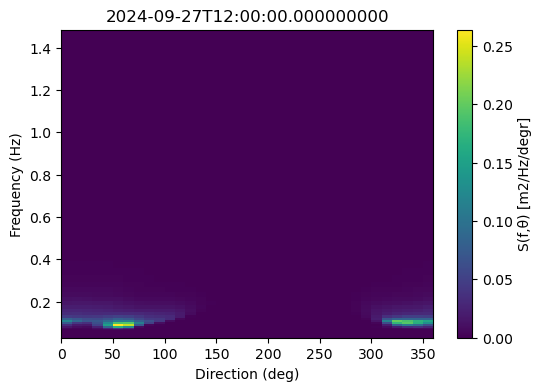

In [24]:
# Example: plot a snapshot 2D spectrum at time index k
k =120
S = ds_spec.S2d.isel(time=k)
# pcolormesh expects edges; quick-and-dirty centers are fine:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
pc = plt.pcolormesh(ds_spec.dir, ds_spec.freq, S, shading='auto')
plt.xlabel("Direction (deg)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(pc, label=f"S(f,θ) [{ds_spec.attrs['units_S2d']}]")
plt.title(str(np.datetime_as_string(ds_spec.time.values[k])))
plt.show()